In [13]:
import pandas as pd

orth_tsv_path = "../data/orthologs/mouse_human_orthologs.tsv"

orth = pd.read_csv(orth_tsv_path, sep="\t")
print("Original columns:", orth.columns.tolist())

cols = list(orth.columns)

human_col_candidates = [c for c in cols if "Gene name" in c and "Mouse" not in c]

mouse_col_candidates = [c for c in cols if "Mouse gene name" in c or "Mus musculus" in c]

print("Human col candidates:", human_col_candidates)
print("Mouse col candidates:", mouse_col_candidates)

if not human_col_candidates or not mouse_col_candidates:
    raise ValueError("Could not automatically find human/mouse gene name columns. Check the printed columns.")

human_col = human_col_candidates[0]
mouse_col = mouse_col_candidates[0]

print("Using human_col =", human_col)
print("Using mouse_col =", mouse_col)

orth = orth.rename(columns={
    human_col: "human_gene",
    mouse_col: "mouse_gene",
})

orth_simple = (
    orth[["mouse_gene", "human_gene"]]
    .dropna()
    .drop_duplicates()
)

orth_simple.to_csv("../data/orthologs/mouse_human_orthologs.csv", index=False)
orth_simple.head()

Original columns: ['Gene stable ID', 'Gene stable ID version', 'Transcript stable ID', 'Transcript stable ID version', 'Mouse gene name', 'Gene name']
Human col candidates: ['Gene name']
Mouse col candidates: ['Mouse gene name']
Using human_col = Gene name
Using mouse_col = Mouse gene name


,mouse_gene,human_gene
5,mt-Nd1,MT-ND1
9,mt-Nd2,MT-ND2
15,mt-Co1,MT-CO1
18,mt-Co2,MT-CO2
20,mt-Atp8,MT-ATP8


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

mouse_markers = pd.read_csv("../results/tables/mouse_leiden_markers.csv")
human_markers = pd.read_csv("../results/tables/human_celltype_markers.csv")
orth          = pd.read_csv("../data/orthologs/mouse_human_orthologs.csv")

mouse_markers.head(), human_markers.head(), orth.head()


(   group   names     scores  logfoldchanges  pvals  pvals_adj
 0      0  Cxcl12  46.203194        8.538551    0.0        0.0
 1      0  Igfbp4  45.123585        6.277569    0.0        0.0
 2      0  Cxcl14  44.985920        8.355460    0.0        0.0
 3      0      Hp  44.762177        7.281410    0.0        0.0
 4      0    Gas6  44.274140        7.186937    0.0        0.0,
        group       names    scores  logfoldchanges  pvals  pvals_adj
 0  Adipo-MSC     PLEKHS1  5.933576        5.933576    0.0        0.0
 1  Adipo-MSC     GALNT17  5.591051        5.591051    0.0        0.0
 2  Adipo-MSC       CCBE1  5.550529        5.550529    0.0        0.0
 3  Adipo-MSC  AL034417.2  5.354651        5.354651    0.0        0.0
 4  Adipo-MSC       CBLN2  5.189141        5.189141    0.0        0.0,
   mouse_gene human_gene
 0     mt-Nd1     MT-ND1
 1     mt-Nd2     MT-ND2
 2     mt-Co1     MT-CO1
 3     mt-Co2     MT-CO2
 4    mt-Atp8    MT-ATP8)

In [15]:
mouse_markers["names_upper"] = mouse_markers["names"].str.upper()
human_markers["names_upper"] = human_markers["names"].str.upper()

orth["mouse_gene_upper"] = orth["mouse_gene"].astype(str).str.upper()
orth["human_gene_upper"] = orth["human_gene"].astype(str).str.upper()

mouse_to_human = (
    orth.dropna(subset=["mouse_gene_upper", "human_gene_upper"])
        .groupby("mouse_gene_upper")["human_gene_upper"]
        .apply(set)
        .to_dict()
)

len(mouse_to_human)


20138

In [16]:
mouse_groups = sorted(mouse_markers["group"].astype(str).unique(), key=str)

mouse_sets_human_space = {}

for g in mouse_groups:
    genes_mouse = (
        mouse_markers.loc[mouse_markers["group"].astype(str) == g, "names_upper"]
        .dropna()
        .unique()
    )
    mapped_human = set()
    for gm in genes_mouse:
        mapped_human.update(mouse_to_human.get(gm, []))
    mouse_sets_human_space[g] = mapped_human

{g: len(mouse_sets_human_space[g]) for g in mouse_groups[:5]}

{'0': 16213, '1': 16213, '10': 16213, '11': 16213, '12': 16213}

In [17]:
human_groups = sorted(human_markers["group"].astype(str).unique(), key=str)

human_sets = {
    g: set(
        human_markers.loc[human_markers["group"].astype(str) == g, "names_upper"]
        .dropna()
        .unique()
    )
    for g in human_groups
}

{g: len(human_sets[g]) for g in human_groups[:5]}

{'AEC': 50,
 'APOD+ MSC': 50,
 'Adipo-MSC': 50,
 'Ba/Eo/Ma': 50,
 'CD4+ T-Cell': 50}

In [18]:
sim_matrix = np.zeros((len(mouse_groups), len(human_groups)), dtype=float)

for i, mg in enumerate(mouse_groups):
    m_set = mouse_sets_human_space[mg]
    for j, hg in enumerate(human_groups):
        h_set = human_sets[hg]
        inter = len(m_set & h_set)
        union = len(m_set | h_set)
        sim_matrix[i, j] = inter / union if union > 0 else 0.0

sim_df = pd.DataFrame(sim_matrix, index=mouse_groups, columns=human_groups)
sim_df.to_csv("../results/tables/mouse_human_niche_similarity_jaccard.csv")

sim_df.round(3).head()

,AEC,APOD+ MSC,Adipo-MSC,Ba/Eo/Ma,CD4+ T-Cell,CD8+ T-Cell,CLP,Cycling DCs,Cycling HSPC,Early Myeloid Progenitor,...,Plasma Cell,Pre-B,Pre-Pro B,Pro-B,RBC,RNAlo MSC,SEC,THY1+ MSC,VSMC,pDC
0,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,...,0.001,0.002,0.002,0.001,0.002,0.003,0.002,0.002,0.002,0.002
1,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,...,0.001,0.002,0.002,0.001,0.002,0.003,0.002,0.002,0.002,0.002
10,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,...,0.001,0.002,0.002,0.001,0.002,0.003,0.002,0.002,0.002,0.002
11,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,...,0.001,0.002,0.002,0.001,0.002,0.003,0.002,0.002,0.002,0.002
12,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,...,0.001,0.002,0.002,0.001,0.002,0.003,0.002,0.002,0.002,0.002


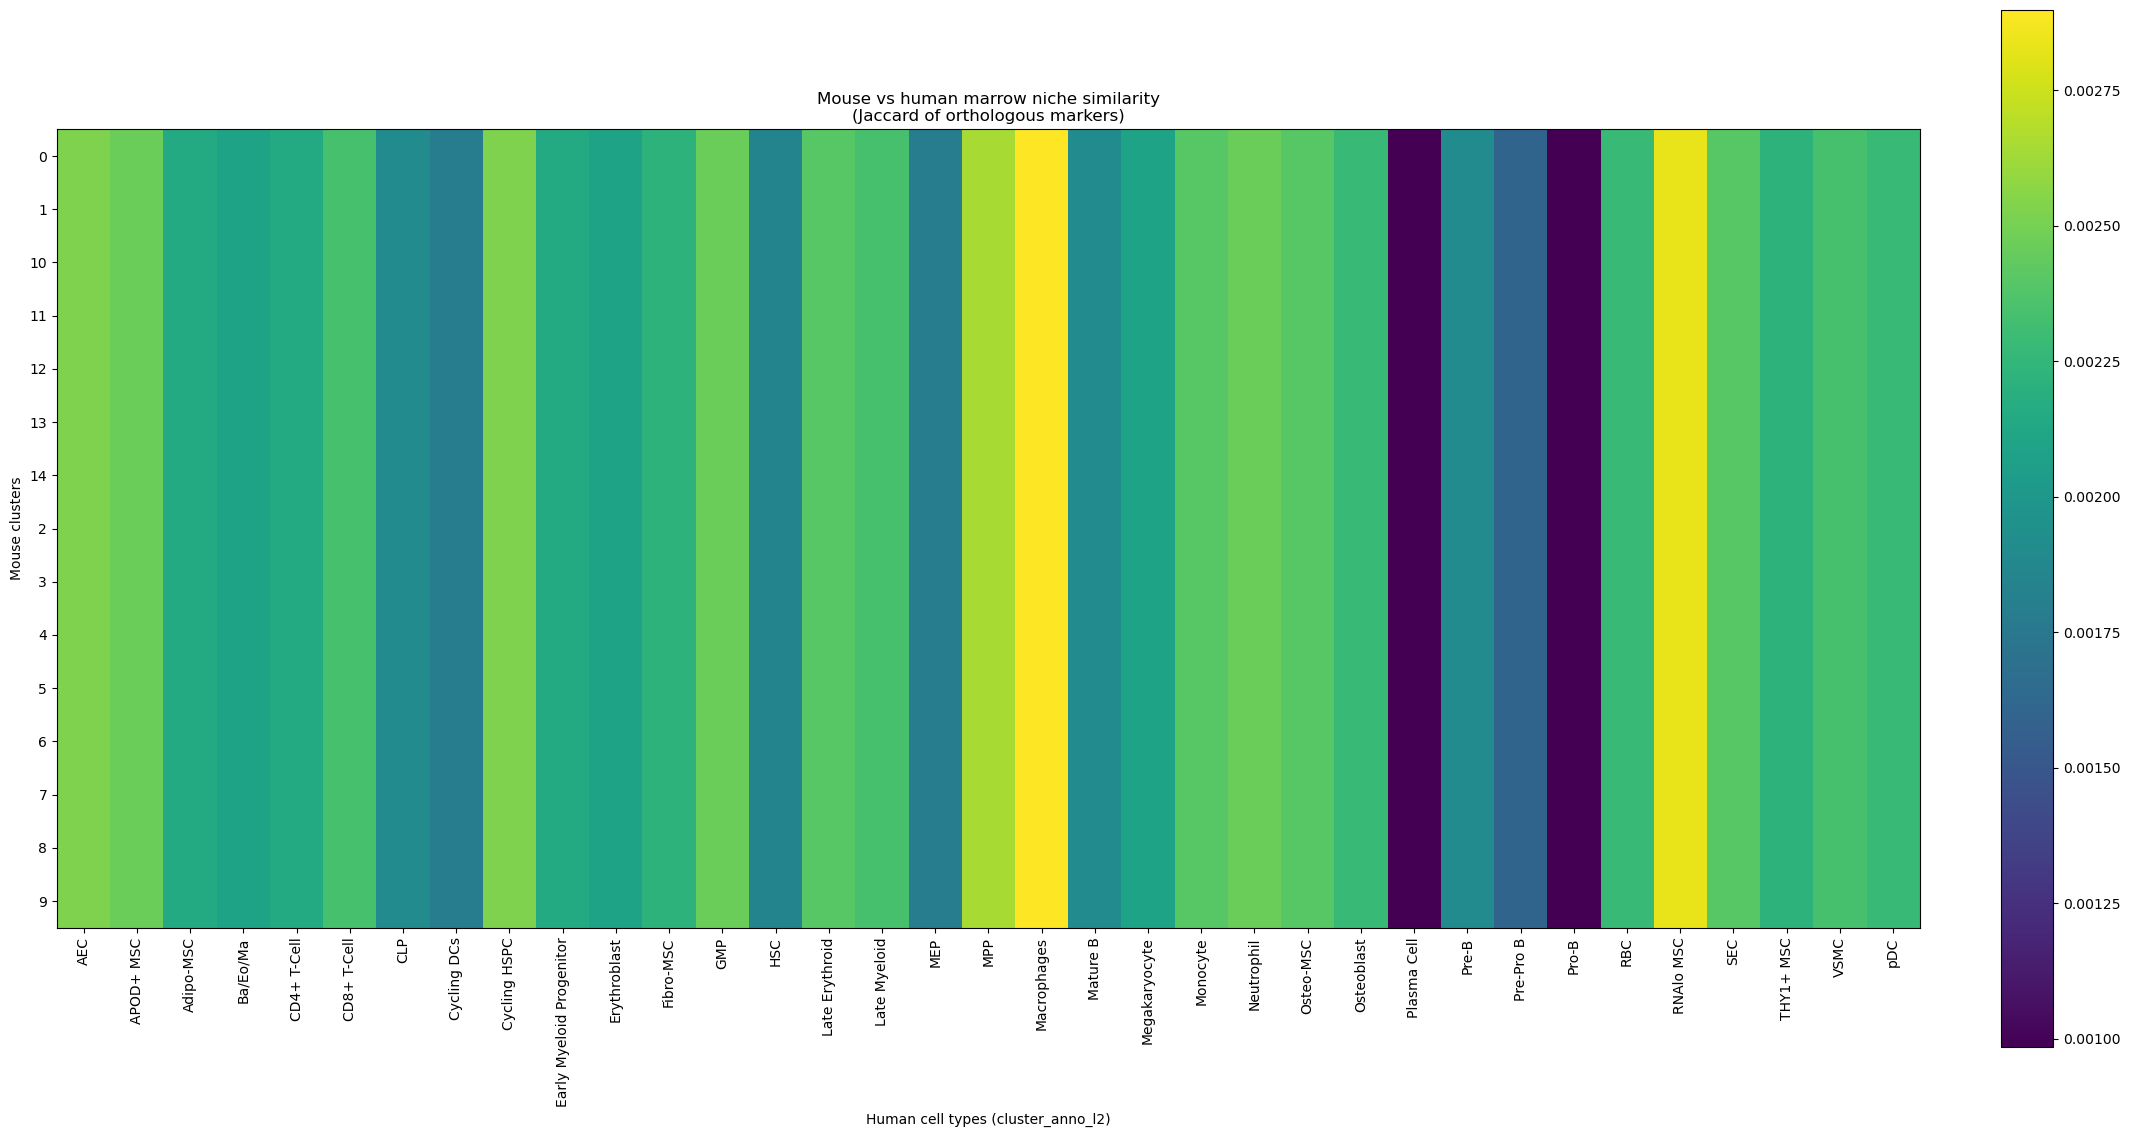

In [19]:
fig, ax = plt.subplots(
    figsize=(0.5 * len(human_groups) + 4, 0.5 * len(mouse_groups) + 4)
)

im = ax.imshow(sim_df.values)

ax.set_xticks(np.arange(len(human_groups)))
ax.set_yticks(np.arange(len(mouse_groups)))

ax.set_xticklabels(human_groups, rotation=90)
ax.set_yticklabels(mouse_groups)

ax.set_xlabel("Human cell types (cluster_anno_l2)")
ax.set_ylabel("Mouse clusters")
ax.set_title("Mouse vs human marrow niche similarity\n(Jaccard of orthologous markers)")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [3]:
import pandas as pd

orth = pd.read_csv("../data/orthologs/mouse_human_orthologs.tsv", sep="\t")
orth = orth.rename(columns={
    "Gene name": "human_gene",
    "Mouse gene name": "mouse_gene",
})
orth = orth[["mouse_gene", "human_gene"]].dropna().drop_duplicates()
orth.to_csv("../data/orthologs/mouse_human_orthologs.csv", index=False)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths
mouse_markers_path = "../results/tables/mouse_leiden_markers.csv"
human_markers_path = "../results/tables/human_celltype_markers.csv"
orthologs_path     = "../data/orthologs/mouse_human_orthologs.csv"

mouse_markers = pd.read_csv(mouse_markers_path)
human_markers = pd.read_csv(human_markers_path)
orth          = pd.read_csv(orthologs_path)

mouse_markers.head(), human_markers.head(), orth.head()

(   group   names     scores  logfoldchanges  pvals  pvals_adj
 0      0  Cxcl12  46.203194        8.538551    0.0        0.0
 1      0  Igfbp4  45.123585        6.277569    0.0        0.0
 2      0  Cxcl14  44.985920        8.355460    0.0        0.0
 3      0      Hp  44.762177        7.281410    0.0        0.0
 4      0    Gas6  44.274140        7.186937    0.0        0.0,
        group       names    scores  logfoldchanges  pvals  pvals_adj
 0  Adipo-MSC     PLEKHS1  5.933576        5.933576    0.0        0.0
 1  Adipo-MSC     GALNT17  5.591051        5.591051    0.0        0.0
 2  Adipo-MSC       CCBE1  5.550529        5.550529    0.0        0.0
 3  Adipo-MSC  AL034417.2  5.354651        5.354651    0.0        0.0
 4  Adipo-MSC       CBLN2  5.189141        5.189141    0.0        0.0,
   mouse_gene human_gene
 0     mt-Nd1     MT-ND1
 1     mt-Nd2     MT-ND2
 2     mt-Co1     MT-CO1
 3     mt-Co2     MT-CO2
 4    mt-Atp8    MT-ATP8)

In [6]:
mouse_markers["names_upper"] = mouse_markers["names"].str.upper()
human_markers["names_upper"] = human_markers["names"].str.upper()

orth["mouse_gene_upper"] = orth["mouse_gene"].astype(str).str.upper()
orth["human_gene_upper"] = orth["human_gene"].astype(str).str.upper()


In [7]:
mouse_to_human = (
    orth.dropna(subset=["mouse_gene_upper", "human_gene_upper"])
        .groupby("mouse_gene_upper")["human_gene_upper"]
        .apply(set)
        .to_dict()
)

len(mouse_to_human)

20138

In [8]:
mouse_groups = sorted(mouse_markers["group"].astype(str).unique(), key=str)

mouse_sets_human_space = {}

for g in mouse_groups:
    genes_mouse = (
        mouse_markers.loc[mouse_markers["group"].astype(str) == g, "names_upper"]
        .dropna()
        .unique()
    )
    mapped_human = set()
    for gm in genes_mouse:
        mapped_human.update(mouse_to_human.get(gm, []))
    mouse_sets_human_space[g] = mapped_human

{g: len(mouse_sets_human_space[g]) for g in mouse_groups[:5]}

{'0': 16213, '1': 16213, '10': 16213, '11': 16213, '12': 16213}

In [9]:
human_groups = sorted(human_markers["group"].astype(str).unique(), key=str)

human_sets = {
    g: set(
        human_markers.loc[human_markers["group"].astype(str) == g, "names_upper"]
        .dropna()
        .unique()
    )
    for g in human_groups
}

{g: len(human_sets[g]) for g in human_groups[:5]}

{'AEC': 50,
 'APOD+ MSC': 50,
 'Adipo-MSC': 50,
 'Ba/Eo/Ma': 50,
 'CD4+ T-Cell': 50}

In [10]:
sim_matrix = np.zeros((len(mouse_groups), len(human_groups)), dtype=float)

for i, mg in enumerate(mouse_groups):
    m_set = mouse_sets_human_space[mg]
    for j, hg in enumerate(human_groups):
        h_set = human_sets[hg]
        inter = len(m_set & h_set)
        union = len(m_set | h_set)
        sim_matrix[i, j] = inter / union if union > 0 else 0.0

sim_df = pd.DataFrame(sim_matrix, index=mouse_groups, columns=human_groups)
sim_df.to_csv("../results/tables/mouse_human_niche_similarity_jaccard.csv")
sim_df.round(3).head()

,AEC,APOD+ MSC,Adipo-MSC,Ba/Eo/Ma,CD4+ T-Cell,CD8+ T-Cell,CLP,Cycling DCs,Cycling HSPC,Early Myeloid Progenitor,...,Plasma Cell,Pre-B,Pre-Pro B,Pro-B,RBC,RNAlo MSC,SEC,THY1+ MSC,VSMC,pDC
0,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,...,0.001,0.002,0.002,0.001,0.002,0.003,0.002,0.002,0.002,0.002
1,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,...,0.001,0.002,0.002,0.001,0.002,0.003,0.002,0.002,0.002,0.002
10,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,...,0.001,0.002,0.002,0.001,0.002,0.003,0.002,0.002,0.002,0.002
11,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,...,0.001,0.002,0.002,0.001,0.002,0.003,0.002,0.002,0.002,0.002
12,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,...,0.001,0.002,0.002,0.001,0.002,0.003,0.002,0.002,0.002,0.002


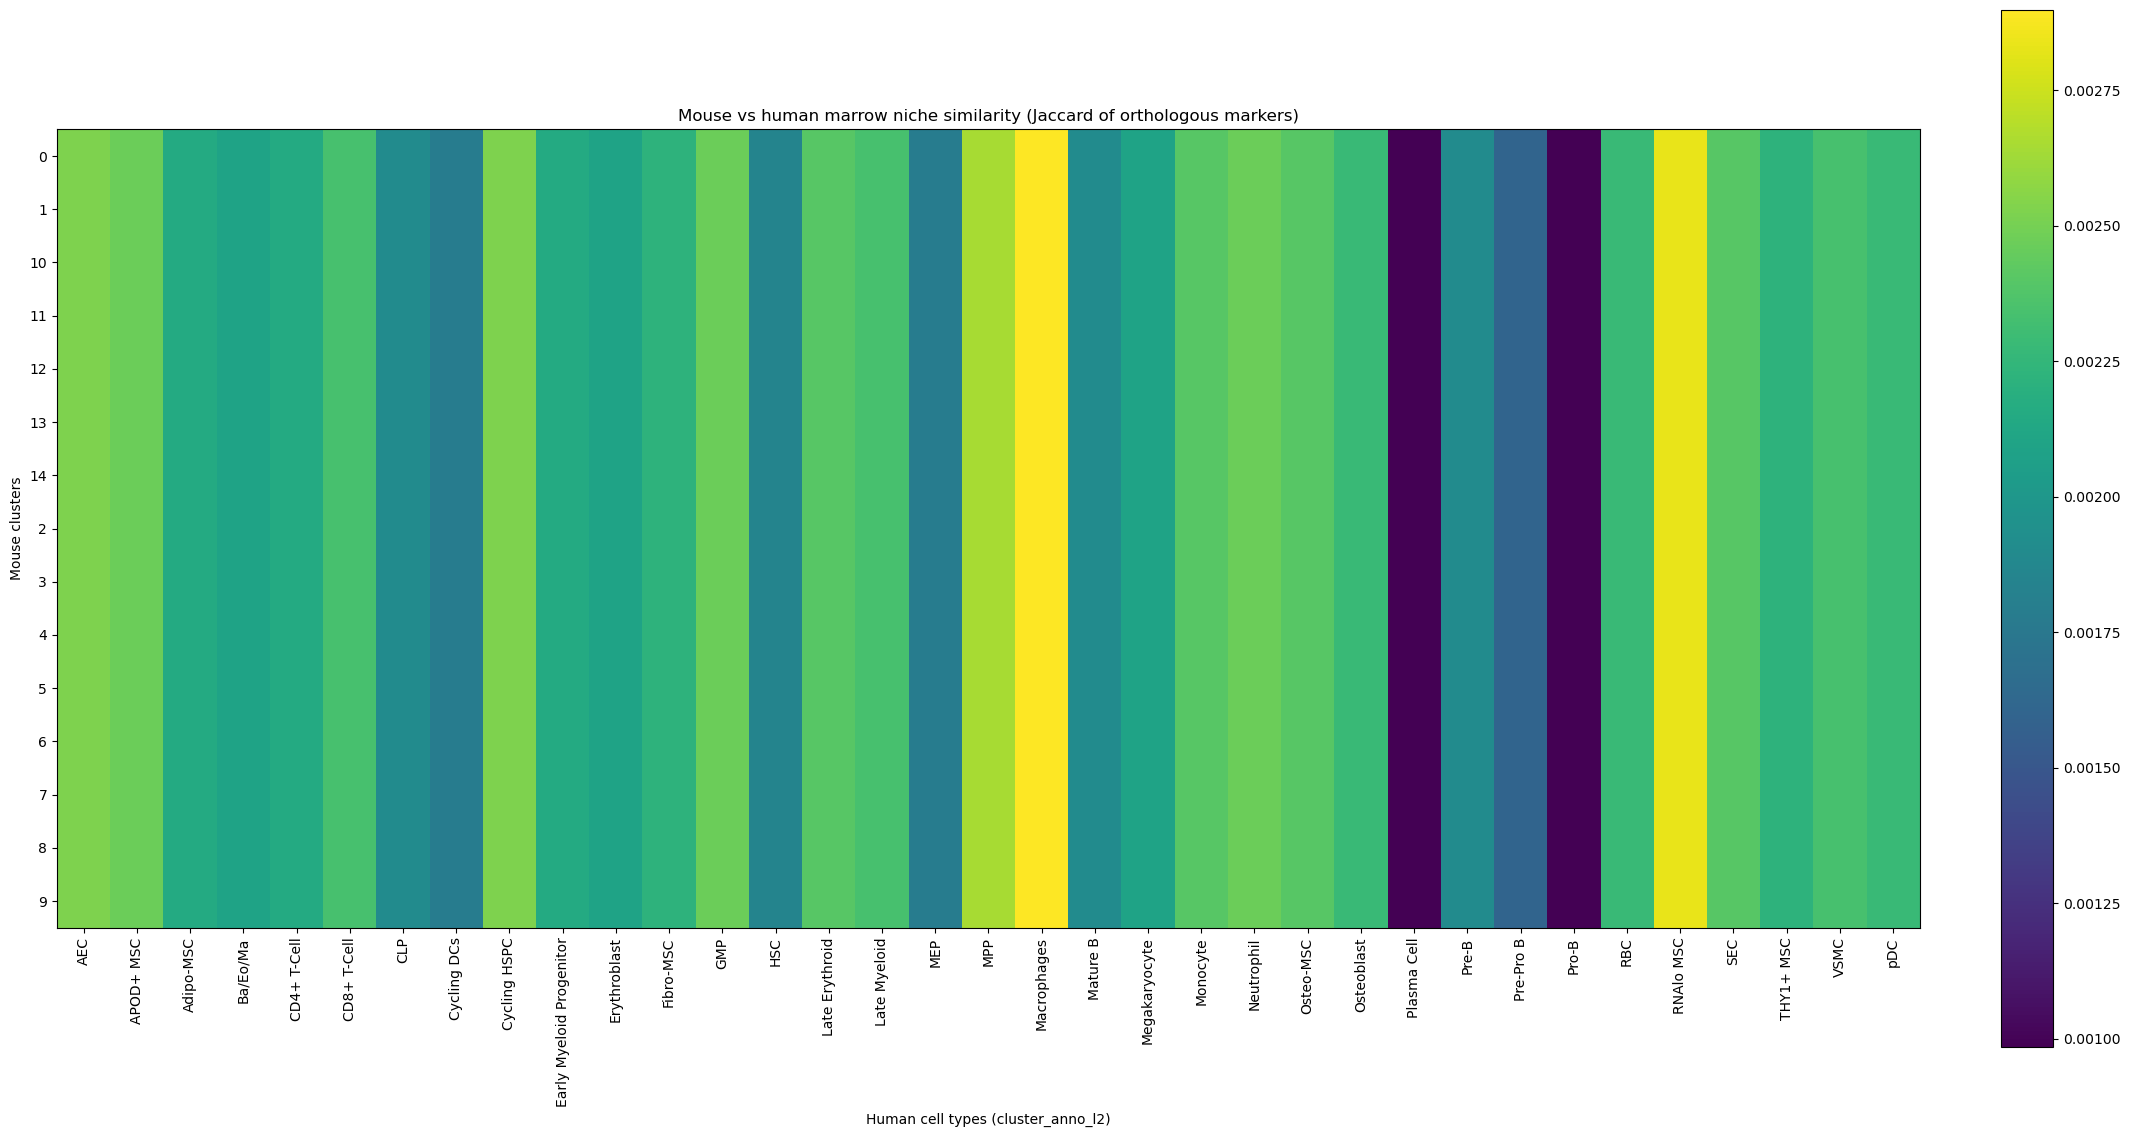

In [11]:
fig, ax = plt.subplots(figsize=(0.5 * len(human_groups) + 4,
                                0.5 * len(mouse_groups) + 4))

im = ax.imshow(sim_df.values)

# Ticks and labels
ax.set_xticks(np.arange(len(human_groups)))
ax.set_yticks(np.arange(len(mouse_groups)))

ax.set_xticklabels(human_groups, rotation=90)
ax.set_yticklabels(mouse_groups)

ax.set_xlabel("Human cell types (cluster_anno_l2)")
ax.set_ylabel("Mouse clusters")

ax.set_title("Mouse vs human marrow niche similarity (Jaccard of orthologous markers)")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [12]:
best_matches = []

for mg in mouse_groups:
    sims = sim_df.loc[mg]
    top_h = sims.sort_values(ascending=False).head(3)
    for hg, val in top_h.items():
        best_matches.append({
            "mouse_group": mg,
            "human_group": hg,
            "similarity_jaccard": val,
        })

best_matches_df = pd.DataFrame(best_matches)
best_matches_df.to_csv("../results/tables/mouse_human_best_matches.csv", index=False)
best_matches_df

,mouse_group,human_group,similarity_jaccard
0,0,Macrophages,0.002898
1,0,RNAlo MSC,0.002837
2,0,MPP,0.002651
3,1,Macrophages,0.002898
4,1,RNAlo MSC,0.002837
5,1,MPP,0.002651
6,10,Macrophages,0.002898
7,10,RNAlo MSC,0.002837
8,10,MPP,0.002651
9,11,Macrophages,0.002898
